In [1]:
import os
seed = 0
os.environ['PYTHONHASSEED'] = str(seed)

In [2]:
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import pickle

from tensorflow.random import set_seed

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [4]:
# Set seed
random.seed(seed)
np.random.seed(seed)
set_seed(seed)

In [5]:
filename = '../data/turbofan_dataset/N-CMAPSS_DS02-006.h5'
output_path = 'DS02/experiment_set_10'

In [6]:
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [7]:
def load_dataset(filename, load_test_set=True):
    """ Reads a dataset from a given .h5 file and compose (in memory) the train and test data. 
    Args:
        filename(str): path to the .h5 file
    Returns:
        train_set(pd.DataFrame), test_set(pd.DataFrame)
    """
    with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        if load_test_set:
            W_test = np.array(hdf.get('W_test'))           # W
            X_s_test = np.array(hdf.get('X_s_test'))       # X_s
            X_v_test = np.array(hdf.get('X_v_test'))       # X_v
            T_test = np.array(hdf.get('T_test'))           # T
            Y_test = np.array(hdf.get('Y_test'))           # RUL  
            A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Column names
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        columns = []
        columns.append(list(np.array(A_var, dtype='U20')))
        columns.append(list(np.array(T_var, dtype='U20')))
        columns.append(list(np.array(X_s_var, dtype='U20')))
        columns.append(list(np.array(X_v_var, dtype='U20')))
        columns.append(list(np.array(W_var, dtype='U20')))
        columns.append(['RUL'])
        
        columns_list = []
        for columns_per_category in columns:
            columns_list += columns_per_category
        
    train_set = np.concatenate((A_dev, T_dev, X_s_dev, X_v_dev, W_dev, Y_dev), axis=1)
    if load_test_set:
        test_set = np.concatenate((A_test, T_test, X_s_test, X_v_test, W_test, Y_test), axis=1)
        return pd.DataFrame(data=train_set, columns=columns_list), pd.DataFrame(data=test_set, columns=columns_list), columns
    else:
        return pd.DataFrame(data=train_set, columns=columns_list), None, columns

In [8]:
def unit_cycle_info(df, compute_cycle_len=False):
    unit_ids = np.unique(df['unit'])
    print('Engine units in df: ', unit_ids)
    for i in unit_ids:
        num_cycles = len(np.unique(df.loc[df['unit'] == i, 'cycle']))
        print('Unit: ', i, ' - Number of flight cycles: ', num_cycles)
        
    if compute_cycle_len:
        cycle_ids = np.unique(df['cycle'])
        print('Total number of cycles: ', len(cycle_ids))
        min_len = np.inf
        max_len = 0
        for i in cycle_ids:
            cycle_len = len(df.loc[df['cycle'] == i, 'cycle'])
            if cycle_len < min_len:
                min_len = cycle_len
            elif cycle_len > max_len:
                max_len = cycle_len
        print('Min cycle length: ', min_len)
        print('Max cycle length: ', max_len)
    
    return unit_ids

In [9]:
# Filter constant and quasi-constant features
def get_quasi_constant_features(dataset, variance_th=0.01, debug=True):
    constant_filter = VarianceThreshold(threshold=variance_th)
    constant_filter.fit(dataset)
    constant_features = [col for col in dataset.columns 
                         if col not in dataset.columns[constant_filter.get_support()]]
    
    if debug:
        print("Number of non-constant features: ", len(dataset.columns[constant_filter.get_support()]))
        
        print("Number of quasi-constant features: ", len(constant_features))
        print("Quasi-constant features: ")
        for col in constant_features:
            print(col)
    return constant_features

def get_non_correlated_features(dataset, corr_th=0.9, debug=True):
    corr_mat = dataset.corr()
    corr_mat = np.abs(corr_mat)
    
    num_cols = corr_mat.shape[0]
    columns = np.full((num_cols,), True, dtype=bool)
    for i in range(num_cols):
        for j in range(i+1, num_cols):
            val = corr_mat.iloc[i, j]
            if val >= corr_th:
                if columns[j]:
                    columns[j] = False
                    if debug:
                        print(dataset.columns[i], "|", dataset.columns[j], "|", round(val, 2))
    if debug:        
        correlated_features = dataset.columns[~columns]
        print("Number of correlated features: ", len(correlated_features))
        print("Correlated features: ", list(correlated_features))
    
    selected_columns = dataset.columns[columns]
    if debug:
        print("Number of selected features: ", len(selected_columns))
        print("Selected features: ", list(selected_columns))
    return selected_columns

def cmapss_score_function(actual, predictions, normalize=True):
    # diff < 0 -> over-estimation
    # diff > 0 -> under-estimation
    diff = actual - predictions
    alpha = np.full_like(diff, 1/13)
    negative_diff_mask = diff < 0
    alpha[negative_diff_mask] = 1/10
    score = np.sum(np.exp(alpha * np.abs(diff)))
    
    if normalize:
        N = len(predictions)
        score /= N
    return score

def compute_evaluation_metrics(actual, predictions, label='Test'):
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    cmapss_score = cmapss_score_function(actual, predictions)
    print('{} set:\nMSE: {:.2f}\nRMSE: {:.2f}\nCMAPSS score: {:.2f}\n'.format(label, mse, rmse, 
                                                                     cmapss_score))
    return mse, rmse, cmapss_score
    
def plot_loss_curves(history, output_path=None, y_lim=[0, 150]):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(y_lim)
    plt.legend(['train', 'validation'], loc='upper left')
    
    if output_path is not None:
        plt.savefig(os.path.join(output_path, 'loss_curves.png'), format='png', dpi=300) 
    plt.show()
    
def plot_rul(expected, predicted):
    plt.figure()
    plt.plot(range(len(expected)), expected, label='Expected')
    plt.plot(range(len(predicted)), predicted, label='Predicted')
    plt.legend()
    
    
def create_mlp_model(input_dim, hidden_layer_sizes, activation='relu', output_weights_file=None):
    model = Sequential()
    model.add(Dense(hidden_layer_sizes[0], 
                    input_dim=input_dim, 
                    kernel_initializer='random_normal', 
                    activation=activation))

    for layer_size in hidden_layer_sizes[1:]:
        model.add(Dense(layer_size, 
                        kernel_initializer='random_normal', 
                        activation=activation))
    
    model.add(Dense(1, kernel_initializer='random_normal'))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    if output_weights_file is not None:
        model.save_weights(output_weights_file)
    return model

def train_model_existing_weights(model, weights_file, x_train, y_train, x_val, y_val, epochs=200, batch_size=512, callbacks=[]):
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.load_weights(weights_file)
    return model.fit(x_train, y_train,
                     validation_data=(x_val, y_val),
                     epochs=epochs,
                     batch_size=batch_size,
                     verbose=1,
                     callbacks=callbacks)

def save_history(history, output_file=os.path.join(output_path, "history.pkl")):
    with open(output_file, 'wb') as file:
        pickle.dump(history.history, file)
    print("Saved training history to file: {}".format(output_file))

def load_history(file):
    return pickle.load(open(file, "rb"))

def save_object(obj, output_file):
    with open(output_file, 'wb') as file:
        pickle.dump(obj, file)
    print("Saved object to file: {}".format(output_file))
    
def load_object(file):
    return pickle.load(open(file, "rb"))

def model_evaluation(model, x_test, y_test, x_train=None, y_train=None, plot_range=[0, 10**3]):
    if x_train is not None and y_train is not None:
        predictions_train = model.predict(x_train).flatten()
        compute_evaluation_metrics(predictions_train, y_train, 'Train')
        
        expected = y_train[plot_range[0]:plot_range[1]]
        predicted = predictions_train[plot_range[0]:plot_range[1]]
        plot_rul(expected, predicted)
        
    predictions_test = model.predict(x_test).flatten()
    compute_evaluation_metrics(predictions_test, y_test)
    
    expected = y_test[plot_range[0]:plot_range[1]]
    predicted = predictions_test[plot_range[0]:plot_range[1]]
    plot_rul(expected, predicted)

In [10]:
def write_list(string_list, output_file):
    output_file.write("[")
    n = len(string_list)
    for i in range(n - 1):
        output_file.write("{}, ".format(string_list[i]))
    output_file.write("{}]\n".format(string_list[-1]))
    
def feature_list_to_string(feature_list):
    return "__".join(feature_list)

def numbers_list_to_string(num_list):
    return " ".join([str(x) for x in num_list])

In [11]:
def get_mi_ranked_features(mi, n):
    mi_sorted = mi.sort_values(by="MI", ascending=False)
    return mi[:n]["Col"].tolist()

In [12]:
start_time = time.process_time()  
train_set, test_set, columns = load_dataset(filename)
print("Operation time (sec): " , (time.process_time() - start_time))
print()
print("Train set shape: " + str(train_set.shape))

columns_aux = columns[0] 
columns_health_params = columns[1] 
columns_sensor_measurements = columns[2] 
columns_virtual_sensors = columns[3]
columns_operating_conditions = columns[4] 
target_col = columns[5]

Operation time (sec):  3.578125

Train set shape: (5263447, 47)


In [29]:
y_train = train_set['RUL']
x_train = train_set.drop(['RUL'], axis=1)

y_test = test_set['RUL']
x_test = test_set.drop(['RUL'], axis=1)

In [14]:
x_train.drop(labels=[x for x in columns_aux if x in x_train.columns], axis=1, inplace=True)

constant_features = get_quasi_constant_features(x_train, variance_th=0.0)
x_train.drop(labels=constant_features, axis=1, inplace=True)
print("Train shape: ", x_train.shape)

Number of non-constant features:  35
Number of quasi-constant features:  7
Quasi-constant features: 
fan_eff_mod
fan_flow_mod
LPC_eff_mod
LPC_flow_mod
HPC_eff_mod
HPC_flow_mod
HPT_flow_mod
Train shape:  (5263447, 35)


In [15]:
x_train, x_mi, y_train, y_mi = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

In [16]:
start_time = time.process_time()  
mi = mutual_info_regression(x_mi, y_mi, random_state=seed)
print("Operation time (sec): " , (time.process_time() - start_time))

mi_series = pd.Series(mi, index=x_train.columns)
mi_series = mi_series.sort_values(ascending=False)
normalized_mi = (mi_series - mi_series.min()) / (mi_series.max() - mi_series.min())

Operation time (sec):  3053.765625


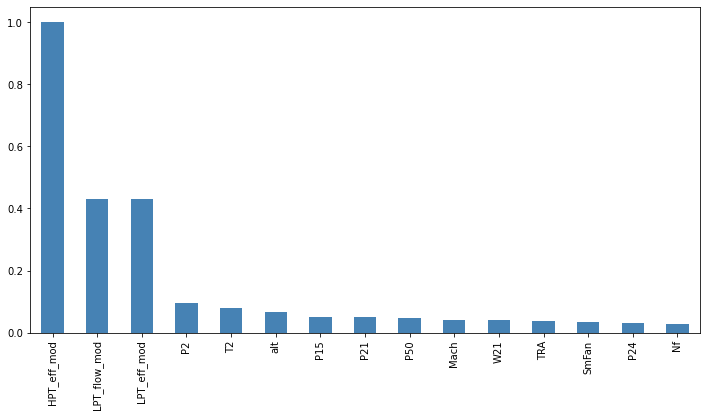

In [17]:
normalized_mi[:15].plot.bar(color='steelblue', figsize=(12, 6))
plt.savefig(os.path.join(output_path, "mutual_info.png"))

In [19]:
normalized_mi.to_csv(os.path.join(output_path, "mi_ranking_42.csv"))

In [23]:
selected_columns = get_mi_ranked_features(mutual_info_series, 10)
x_train_feature_selection = x_train[selected_columns]

In [33]:
x_train = x_train.astype(np.float32)

In [34]:
y_train = y_train.astype(np.float32)

In [35]:
train_unit_ids = unit_cycle_info(x_train)

Engine units in df:  [ 2.  5. 10. 16. 18. 20.]
Unit:  2.0  - Number of flight cycles:  75
Unit:  5.0  - Number of flight cycles:  89
Unit:  10.0  - Number of flight cycles:  82
Unit:  16.0  - Number of flight cycles:  63
Unit:  18.0  - Number of flight cycles:  71
Unit:  20.0  - Number of flight cycles:  66


In [36]:
selected_columns

['HPT_eff_mod',
 'LPT_flow_mod',
 'LPT_eff_mod',
 'P2',
 'T2',
 'alt',
 'P50',
 'P21',
 'P15',
 'Mach']

In [25]:
def time_window_processing(X, y, column_names, unit_ids, window_size):
    df = pd.concat([X, y], axis=1)
    lag_columns = []
    
    for col_name in column_names:
        for i in range(1, window_size):
            partial_columns = []
            for j in range(len(unit_ids)):
                unit_df = df.loc[df['unit'] == unit_ids[j], :]
                col = unit_df[col_name].shift(i)
                col.name = '{}(t-{})'.format(col_name, i)
                partial_columns.append(col)
            column = pd.concat(partial_columns)
            lag_columns.append(column)
    
    df = pd.concat([df] + lag_columns, axis=1)
    df.dropna(inplace=True)
    df.drop(labels=['unit'], axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    feature_columns = [col for col in df.columns.values if col != 'RUL']    
    return df[feature_columns], df['RUL']

In [25]:
# corr = x_train.corrwith(y_train)
# abs_corr = np.abs(corr)

In [28]:
# abs_corr = abs_corr.sort_values(ascending=False)

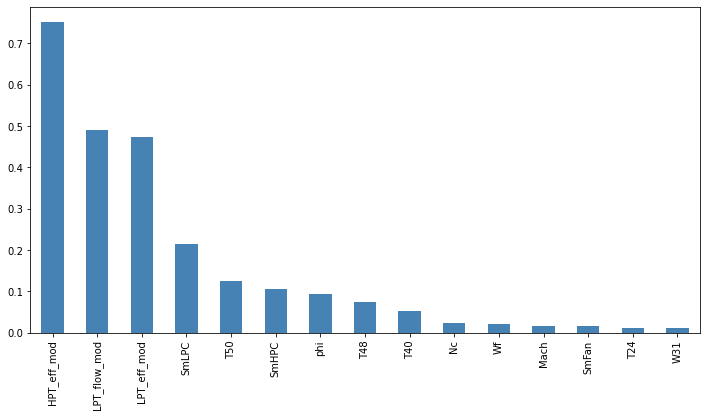

In [29]:
# abs_corr[:15].plot.bar(color='steelblue', figsize=(12, 6))
# plt.savefig(os.path.join(output_path, "correlation.png"))

In [21]:
mutual_info_series = pd.read_csv(os.path.join(output_path, "mutual_info.csv"))

In [15]:
x_train, x_holdout, y_train, y_holdout = train_test_split(x_train, 
                                                          y_train, 
                                                          test_size=0.3, 
                                                          random_state=seed)

In [16]:
###########################################
# Test effect of mutual information ranking
###########################################
NUM_TRIALS = 3

batch_size = 512
epochs = 200
layer_sizes = [256, 256, 512, 64]

num_selected_columns = [10, 15, 20, 25]

results_file = os.path.join(output_path, "results_mi_ranking.csv")
with open(results_file, "w") as file:
    file.write("selected_features,num_features,mse,rmse,cmapss,mse(mean),mse(std),rmse(mean),rmse(std),cmapss(mean),cmapss(std)\n")


for n in num_selected_columns:
    selected_columns = get_mi_ranked_features(mutual_info_series, n)
    x_train_feature_selection = x_train[selected_columns]
    
    mse_vals = []
    rmse_vals = []
    cmapss_vals = []
    
    for random_seed in range(NUM_TRIALS):
        # Train-validation split for early stopping
        x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train_feature_selection, 
                                                                                  y_train, 
                                                                                  test_size=0.1, 
                                                                                  random_state=random_seed)
        # Create output path
        results_folder ="results_{}".format(n)
        results_path_crr_num = os.path.join(output_path, results_folder)
        results_path_crr_split = os.path.join(results_path_crr_num, "split_{}".format(random_seed))
        if not os.path.exists(results_path_crr_split):
            os.makedirs(results_path_crr_split)

        # Standardization
        scaler_file = os.path.join(results_path_crr_split, 'scaler.pkl')
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train_split)
        x_val_scaled = scaler.transform(x_val_split)
        input_dim = x_train_scaled.shape[1]
        save_object(scaler, scaler_file)

        # Create model
        weights_file = os.path.join(results_path_crr_num, 'mlp_initial_weights.h5')
        model_path = os.path.join(results_path_crr_split, 'mlp_model_trained.h5')
        
        # Save initial weights
        if random_seed == 0:
            model = create_mlp_model(input_dim, layer_sizes, activation='tanh',
                                     output_weights_file=weights_file)
        else:
            model = create_mlp_model(input_dim, layer_sizes, activation='tanh')
        model.summary()

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=2, 
                             save_best_only=True)

        # Train model
        history = train_model_existing_weights(model, weights_file, 
                                               x_train_scaled, y_train_split, 
                                               x_val_scaled, y_val_split, 
                                               batch_size=batch_size, 
                                               epochs=epochs, 
                                               callbacks=[es, mc])

        history_file = os.path.join(results_path_crr_split, "history.pkl")
        save_history(history, history_file)

        # Performance evaluation
        x_holdout_feature_selection = x_holdout[selected_columns]
        x_holdout_scaled = scaler.transform(x_holdout_feature_selection)

        loaded_model = load_model(model_path)
        predictions_holdout = loaded_model.predict(x_holdout_scaled).flatten()
        mse, rmse, cmapss_score = compute_evaluation_metrics(predictions_holdout, y_holdout)
        
        mse_vals.append(mse)
        rmse_vals.append(rmse)
        cmapss_vals.append(cmapss_score)
    
    mse_mean = np.mean(mse_vals)
    mse_std = np.std(mse_vals)
    rmse_mean = np.mean(rmse_vals)
    rmse_std = np.std(rmse_vals)
    cmapss_mean = np.mean(cmapss_vals)
    cmapss_std = np.std(cmapss_vals)
    
    with open(results_file, "a") as file:
        file.write(f"{feature_list_to_string(selected_columns)}, {len(selected_columns)}, {numbers_list_to_string(mse_vals)}, {numbers_list_to_string(rmse_vals)}, {numbers_list_to_string(cmapss_vals)}, {mse_mean}, {mse_std}, {rmse_mean}, {rmse_std}, {cmapss_mean}, {cmapss_std}\n")

Saved object to file: DS02/experiment_set_10\results_10\split_0\scaler.pkl
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2816      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 233,089
Trainable params: 233,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
6477/6477 [==================

Epoch 28/200
6477/6477 [==============================] - ETA: 0s - loss: 1.8582
Epoch 00028: val_loss did not improve from 1.43415
6477/6477 [==============================] - 27s 4ms/step - loss: 1.8582 - val_loss: 1.7358
Epoch 29/200
6465/6477 [============================>.] - ETA: 0s - loss: 1.8269
Epoch 00029: val_loss did not improve from 1.43415
6477/6477 [==============================] - 26s 4ms/step - loss: 1.8264 - val_loss: 1.5097
Epoch 30/200
6465/6477 [============================>.] - ETA: 0s - loss: 1.7593
Epoch 00030: val_loss did not improve from 1.43415
6477/6477 [==============================] - 26s 4ms/step - loss: 1.7593 - val_loss: 1.5826
Epoch 31/200
6470/6477 [============================>.] - ETA: 0s - loss: 1.7577
Epoch 00031: val_loss improved from 1.43415 to 1.42008, saving model to DS02/experiment_set_10\results_10\split_0\mlp_model_trained.h5
6477/6477 [==============================] - 27s 4ms/step - loss: 1.7573 - val_loss: 1.4201
Epoch 32/200
6471/64

6474/6477 [============================>.] - ETA: 0s - loss: 1.5699
Epoch 00044: val_loss improved from 1.32487 to 1.24390, saving model to DS02/experiment_set_10\results_10\split_1\mlp_model_trained.h5
6477/6477 [==============================] - 26s 4ms/step - loss: 1.5701 - val_loss: 1.2439
Epoch 45/200
6474/6477 [============================>.] - ETA: 0s - loss: 1.5475
Epoch 00045: val_loss improved from 1.24390 to 1.20989, saving model to DS02/experiment_set_10\results_10\split_1\mlp_model_trained.h5
6477/6477 [==============================] - 26s 4ms/step - loss: 1.5474 - val_loss: 1.2099
Epoch 46/200
6465/6477 [============================>.] - ETA: 0s - loss: 1.5477
Epoch 00046: val_loss did not improve from 1.20989
6477/6477 [==============================] - 26s 4ms/step - loss: 1.5469 - val_loss: 1.2686
Epoch 47/200
6477/6477 [==============================] - ETA: 0s - loss: 1.5236- ETA: 1 - ETA: 0s - loss:
Epoch 00047: val_loss did not improve from 1.20989
6477/6477 [====

Epoch 78/200
6473/6477 [============================>.] - ETA: 0s - loss: 1.2333
Epoch 00078: val_loss did not improve from 0.95778
6477/6477 [==============================] - 26s 4ms/step - loss: 1.2333 - val_loss: 1.1536
Epoch 79/200
6473/6477 [============================>.] - ETA: 0s - loss: 1.2225
Epoch 00079: val_loss did not improve from 0.95778
6477/6477 [==============================] - 26s 4ms/step - loss: 1.2226 - val_loss: 1.4343
Epoch 80/200
6469/6477 [============================>.] - ETA: 0s - loss: 1.2215
Epoch 00080: val_loss did not improve from 0.95778
6477/6477 [==============================] - 26s 4ms/step - loss: 1.2217 - val_loss: 1.1446
Epoch 00080: early stopping
Saved training history to file: DS02/experiment_set_10\results_10\split_1\history.pkl
Test set:
MSE: 0.97
RMSE: 0.99
CMAPSS score: 1.04

Saved object to file: DS02/experiment_set_10\results_10\split_2\scaler.pkl
Model: "sequential_2"
_________________________________________________________________


6477/6477 [==============================] - ETA: 0s - loss: 1.5671
Epoch 00057: val_loss did not improve from 1.19196
6477/6477 [==============================] - 26s 4ms/step - loss: 1.5671 - val_loss: 2.6923
Epoch 58/200
6469/6477 [============================>.] - ETA: 0s - loss: 1.5215
Epoch 00058: val_loss did not improve from 1.19196
6477/6477 [==============================] - 26s 4ms/step - loss: 1.5218 - val_loss: 1.5502
Epoch 59/200
6475/6477 [============================>.] - ETA: 0s - loss: 1.5174
Epoch 00059: val_loss did not improve from 1.19196
6477/6477 [==============================] - 26s 4ms/step - loss: 1.5176 - val_loss: 1.8423
Epoch 00059: early stopping
Saved training history to file: DS02/experiment_set_10\results_10\split_2\history.pkl
Test set:
MSE: 1.18
RMSE: 1.09
CMAPSS score: 1.05

Saved object to file: DS02/experiment_set_10\results_15\split_0\scaler.pkl
Model: "sequential_3"
_________________________________________________________________
Layer (type) 

Epoch 25/200
6468/6477 [============================>.] - ETA: 0s - loss: 1.7886
Epoch 00025: val_loss improved from 1.52975 to 1.50889, saving model to DS02/experiment_set_10\results_15\split_0\mlp_model_trained.h5
6477/6477 [==============================] - 27s 4ms/step - loss: 1.7884 - val_loss: 1.5089
Epoch 26/200
6476/6477 [============================>.] - ETA: 0s - loss: 1.7914- ETA: 0s -
Epoch 00026: val_loss did not improve from 1.50889
6477/6477 [==============================] - 26s 4ms/step - loss: 1.7915 - val_loss: 1.6762
Epoch 27/200
6474/6477 [============================>.] - ETA: 0s - loss: 1.7365
Epoch 00027: val_loss did not improve from 1.50889
6477/6477 [==============================] - 26s 4ms/step - loss: 1.7367 - val_loss: 1.8740
Epoch 28/200
6466/6477 [============================>.] - ETA: 0s - loss: 1.7443
Epoch 00028: val_loss did not improve from 1.50889
6477/6477 [==============================] - 26s 4ms/step - loss: 1.7447 - val_loss: 1.6499
Epoch 29/

Epoch 1/200
6473/6477 [============================>.] - ETA: 0s - loss: 130.9978- ETA: 0s
Epoch 00001: val_loss improved from inf to 16.88487, saving model to DS02/experiment_set_10\results_15\split_1\mlp_model_trained.h5
6477/6477 [==============================] - 26s 4ms/step - loss: 130.9359 - val_loss: 16.8849
Epoch 2/200
6474/6477 [============================>.] - ETA: 0s - loss: 13.3009
Epoch 00002: val_loss improved from 16.88487 to 8.67516, saving model to DS02/experiment_set_10\results_15\split_1\mlp_model_trained.h5
6477/6477 [==============================] - 26s 4ms/step - loss: 13.2996 - val_loss: 8.6752
Epoch 3/200
6474/6477 [============================>.] - ETA: 0s - loss: 7.5009
Epoch 00003: val_loss improved from 8.67516 to 5.69988, saving model to DS02/experiment_set_10\results_15\split_1\mlp_model_trained.h5
6477/6477 [==============================] - 26s 4ms/step - loss: 7.5002 - val_loss: 5.6999
Epoch 4/200
6468/6477 [============================>.] - ETA: 0s 

Epoch 10/200
6473/6477 [============================>.] - ETA: 0s - loss: 3.0376
Epoch 00010: val_loss did not improve from 3.39115
6477/6477 [==============================] - 30s 5ms/step - loss: 3.0381 - val_loss: 4.9702
Epoch 11/200
6473/6477 [============================>.] - ETA: 0s - loss: 2.9038
Epoch 00011: val_loss improved from 3.39115 to 2.87954, saving model to DS02/experiment_set_10\results_15\split_2\mlp_model_trained.h5
6477/6477 [==============================] - 28s 4ms/step - loss: 2.9041 - val_loss: 2.8795
Epoch 12/200
6477/6477 [==============================] - ETA: 0s - loss: 2.7573
Epoch 00012: val_loss improved from 2.87954 to 2.47545, saving model to DS02/experiment_set_10\results_15\split_2\mlp_model_trained.h5
6477/6477 [==============================] - 27s 4ms/step - loss: 2.7573 - val_loss: 2.4755
Epoch 13/200
6474/6477 [============================>.] - ETA: 0s - loss: 2.6170
Epoch 00013: val_loss improved from 2.47545 to 2.20045, saving model to DS02/ex

6477/6477 [==============================] - 25s 4ms/step - loss: 1.4430 - val_loss: 1.1574
Epoch 42/200
6474/6477 [============================>.] - ETA: 0s - loss: 1.4295
Epoch 00042: val_loss did not improve from 1.15735
6477/6477 [==============================] - 26s 4ms/step - loss: 1.4293 - val_loss: 1.3949
Epoch 43/200
6466/6477 [============================>.] - ETA: 0s - loss: 1.4455
Epoch 00043: val_loss did not improve from 1.15735
6477/6477 [==============================] - 26s 4ms/step - loss: 1.4450 - val_loss: 1.2266
Epoch 44/200
6464/6477 [============================>.] - ETA: 0s - loss: 1.3944
Epoch 00044: val_loss did not improve from 1.15735
6477/6477 [==============================] - 26s 4ms/step - loss: 1.3960 - val_loss: 1.8871
Epoch 45/200
6466/6477 [============================>.] - ETA: 0s - loss: 1.3971
Epoch 00045: val_loss did not improve from 1.15735
6477/6477 [==============================] - 25s 4ms/step - loss: 1.3969 - val_loss: 1.1646
Epoch 46/200

Epoch 11/200
6469/6477 [============================>.] - ETA: 0s - loss: 2.9371
Epoch 00011: val_loss improved from 2.93415 to 2.28668, saving model to DS02/experiment_set_10\results_20\split_0\mlp_model_trained.h5
6477/6477 [==============================] - 26s 4ms/step - loss: 2.9364 - val_loss: 2.2867
Epoch 12/200
6477/6477 [==============================] - ETA: 0s - loss: 2.7813
Epoch 00012: val_loss did not improve from 2.28668
6477/6477 [==============================] - 26s 4ms/step - loss: 2.7813 - val_loss: 2.3777
Epoch 13/200
6472/6477 [============================>.] - ETA: 0s - loss: 2.6721- ETA: 0s - loss: 2.672
Epoch 00013: val_loss improved from 2.28668 to 2.17527, saving model to DS02/experiment_set_10\results_20\split_0\mlp_model_trained.h5
6477/6477 [==============================] - 26s 4ms/step - loss: 2.6721 - val_loss: 2.1753
Epoch 14/200
6468/6477 [============================>.] - ETA: 0s - loss: 2.4815
Epoch 00014: val_loss improved from 2.17527 to 2.06495, 

6477/6477 [==============================] - 26s 4ms/step - loss: 1.6966 - val_loss: 1.3834
Epoch 34/200
6474/6477 [============================>.] - ETA: 0s - loss: 1.6652
Epoch 00034: val_loss did not improve from 1.38339
6477/6477 [==============================] - 25s 4ms/step - loss: 1.6649 - val_loss: 1.4658
Epoch 35/200
6473/6477 [============================>.] - ETA: 0s - loss: 1.6715
Epoch 00035: val_loss did not improve from 1.38339
6477/6477 [==============================] - 26s 4ms/step - loss: 1.6717 - val_loss: 1.6189
Epoch 36/200
6468/6477 [============================>.] - ETA: 0s - loss: 1.6257
Epoch 00036: val_loss improved from 1.38339 to 1.32968, saving model to DS02/experiment_set_10\results_20\split_1\mlp_model_trained.h5
6477/6477 [==============================] - 26s 4ms/step - loss: 1.6256 - val_loss: 1.3297
Epoch 37/200
6464/6477 [============================>.] - ETA: 0s - loss: 1.6487
Epoch 00037: val_loss improved from 1.32968 to 1.29815, saving model to

Epoch 67/200
6474/6477 [============================>.] - ETA: 0s - loss: 1.3104
Epoch 00067: val_loss did not improve from 0.98643
6477/6477 [==============================] - 26s 4ms/step - loss: 1.3104 - val_loss: 1.0272
Epoch 68/200
6469/6477 [============================>.] - ETA: 0s - loss: 1.2863- ETA: 0s - loss: 1.28
Epoch 00068: val_loss did not improve from 0.98643
6477/6477 [==============================] - 26s 4ms/step - loss: 1.2862 - val_loss: 1.0042
Epoch 69/200
6469/6477 [============================>.] - ETA: 0s - loss: 1.2875
Epoch 00069: val_loss did not improve from 0.98643
6477/6477 [==============================] - 26s 4ms/step - loss: 1.2872 - val_loss: 1.1745
Epoch 00069: early stopping
Saved training history to file: DS02/experiment_set_10\results_20\split_1\history.pkl
Test set:
MSE: 1.01
RMSE: 1.01
CMAPSS score: 1.05

Saved object to file: DS02/experiment_set_10\results_20\split_2\scaler.pkl
Model: "sequential_8"
____________________________________________

Epoch 25/200
6467/6477 [============================>.] - ETA: 0s - loss: 1.9569
Epoch 00025: val_loss did not improve from 1.75655
6477/6477 [==============================] - 26s 4ms/step - loss: 1.9566 - val_loss: 1.9317
Epoch 26/200
6465/6477 [============================>.] - ETA: 0s - loss: 1.9334
Epoch 00026: val_loss did not improve from 1.75655
6477/6477 [==============================] - 26s 4ms/step - loss: 1.9329 - val_loss: 1.9577
Epoch 27/200
6466/6477 [============================>.] - ETA: 0s - loss: 1.8869- ETA:  - ETA: 4s - 
Epoch 00027: val_loss improved from 1.75655 to 1.59494, saving model to DS02/experiment_set_10\results_20\split_2\mlp_model_trained.h5
6477/6477 [==============================] - 26s 4ms/step - loss: 1.8872 - val_loss: 1.5949
Epoch 28/200
6470/6477 [============================>.] - ETA: 0s - loss: 1.8323
Epoch 00028: val_loss improved from 1.59494 to 1.52681, saving model to DS02/experiment_set_10\results_20\split_2\mlp_model_trained.h5
6477/647

6469/6477 [============================>.] - ETA: 0s - loss: 2.6714
Epoch 00015: val_loss improved from 2.47443 to 2.20841, saving model to DS02/experiment_set_10\results_25\split_0\mlp_model_trained.h5
6477/6477 [==============================] - 26s 4ms/step - loss: 2.6710 - val_loss: 2.2084
Epoch 16/200
6472/6477 [============================>.] - ETA: 0s - loss: 2.6553
Epoch 00016: val_loss did not improve from 2.20841
6477/6477 [==============================] - 26s 4ms/step - loss: 2.6552 - val_loss: 2.3626
Epoch 17/200
6474/6477 [============================>.] - ETA: 0s - loss: 2.5255
Epoch 00017: val_loss did not improve from 2.20841
6477/6477 [==============================] - 26s 4ms/step - loss: 2.5253 - val_loss: 2.2433
Epoch 18/200
6470/6477 [============================>.] - ETA: 0s - loss: 2.4697
Epoch 00018: val_loss improved from 2.20841 to 2.13232, saving model to DS02/experiment_set_10\results_25\split_0\mlp_model_trained.h5
6477/6477 [==============================

Epoch 1/200
6473/6477 [============================>.] - ETA: 0s - loss: 120.6835
Epoch 00001: val_loss improved from inf to 16.56830, saving model to DS02/experiment_set_10\results_25\split_1\mlp_model_trained.h5
6477/6477 [==============================] - 25s 4ms/step - loss: 120.6266 - val_loss: 16.5683
Epoch 2/200
6470/6477 [============================>.] - ETA: 0s - loss: 14.0081
Epoch 00002: val_loss improved from 16.56830 to 10.94052, saving model to DS02/experiment_set_10\results_25\split_1\mlp_model_trained.h5
6477/6477 [==============================] - 26s 4ms/step - loss: 14.0057 - val_loss: 10.9405
Epoch 3/200
6477/6477 [==============================] - ETA: 0s - loss: 8.6365- ETA: 0s - loss: 8.6
Epoch 00003: val_loss improved from 10.94052 to 6.28853, saving model to DS02/experiment_set_10\results_25\split_1\mlp_model_trained.h5
6477/6477 [==============================] - 27s 4ms/step - loss: 8.6365 - val_loss: 6.2885
Epoch 4/200
6466/6477 [===========================

Epoch 15/200
6468/6477 [============================>.] - ETA: 0s - loss: 2.5953
Epoch 00015: val_loss did not improve from 2.09553
6477/6477 [==============================] - 26s 4ms/step - loss: 2.5947 - val_loss: 2.3533
Epoch 16/200
6474/6477 [============================>.] - ETA: 0s - loss: 2.5724
Epoch 00016: val_loss did not improve from 2.09553
6477/6477 [==============================] - 25s 4ms/step - loss: 2.5724 - val_loss: 2.4141
Epoch 17/200
6473/6477 [============================>.] - ETA: 0s - loss: 2.3825
Epoch 00017: val_loss improved from 2.09553 to 2.01829, saving model to DS02/experiment_set_10\results_25\split_2\mlp_model_trained.h5
6477/6477 [==============================] - 26s 4ms/step - loss: 2.3820 - val_loss: 2.0183
Epoch 18/200
6474/6477 [============================>.] - ETA: 0s - loss: 2.3524
Epoch 00018: val_loss did not improve from 2.01829
6477/6477 [==============================] - 26s 4ms/step - loss: 2.3523 - val_loss: 2.3975
Epoch 19/200
6465/64

In [18]:
######################################################
# Results on test set
######################################################
NUM_TRIALS = 3

batch_size = 512
epochs = 200
layer_sizes = [256, 256, 512, 64]

num_selected_columns = [10, 15, 20, 25]

results_file = os.path.join(output_path, "results_mi_ranking_test_set.csv")
with open(results_file, "w") as file:
    file.write("selected_features,num_features,mse,rmse,cmapss,mse(mean),mse(std),rmse(mean),rmse(std),cmapss(mean),cmapss(std)\n")


for n in num_selected_columns:
    selected_columns = get_mi_ranked_features(mutual_info_series, n)
    
    mse_vals = []
    rmse_vals = []
    cmapss_vals = []
    
    for random_seed in range(NUM_TRIALS):
        results_folder ="results_{}".format(n)
        results_path_crr_th = os.path.join(output_path, results_folder)
        results_path_crr_split = os.path.join(results_path_crr_th, "split_{}".format(random_seed))
        
        scaler_file = os.path.join(results_path_crr_split, 'scaler.pkl')
        scaler = load_object(scaler_file)

        model_path = os.path.join(results_path_crr_split, 'mlp_model_trained.h5')
        
        # Performance evaluation
        x_test_feature_selection = x_test[selected_columns]
        x_test_scaled = scaler.transform(x_test_feature_selection)

        loaded_model = load_model(model_path)
        predictions_test = loaded_model.predict(x_test_scaled).flatten()
        mse, rmse, cmapss_score = compute_evaluation_metrics(predictions_test, y_test)
        
        mse_vals.append(mse)
        rmse_vals.append(rmse)
        cmapss_vals.append(cmapss_score)
    
    mse_mean = np.mean(mse_vals)
    mse_std = np.std(mse_vals)
    rmse_mean = np.mean(rmse_vals)
    rmse_std = np.std(rmse_vals)
    cmapss_mean = np.mean(cmapss_vals)
    cmapss_std = np.std(cmapss_vals)
    
    with open(results_file, "a") as file:
        file.write(f"{feature_list_to_string(selected_columns)}, {len(selected_columns)}, {numbers_list_to_string(mse_vals)}, {numbers_list_to_string(rmse_vals)}, {numbers_list_to_string(cmapss_vals)}, {mse_mean}, {mse_std}, {rmse_mean}, {rmse_std}, {cmapss_mean}, {cmapss_std}\n")

Test set:
MSE: 25.56
RMSE: 5.06
CMAPSS score: 1.46

Test set:
MSE: 39.02
RMSE: 6.25
CMAPSS score: 1.62

Test set:
MSE: 34.20
RMSE: 5.85
CMAPSS score: 1.55

Test set:
MSE: 44.83
RMSE: 6.70
CMAPSS score: 1.65

Test set:
MSE: 39.70
RMSE: 6.30
CMAPSS score: 1.59

Test set:
MSE: 40.34
RMSE: 6.35
CMAPSS score: 1.60

Test set:
MSE: 38.40
RMSE: 6.20
CMAPSS score: 1.61

Test set:
MSE: 39.08
RMSE: 6.25
CMAPSS score: 1.61

Test set:
MSE: 36.48
RMSE: 6.04
CMAPSS score: 1.57

Test set:
MSE: 33.06
RMSE: 5.75
CMAPSS score: 1.54

Test set:
MSE: 33.03
RMSE: 5.75
CMAPSS score: 1.54

Test set:
MSE: 33.37
RMSE: 5.78
CMAPSS score: 1.55

